# Multicellular Factor Analysis

## Background

In [Ramirez et al, 2023](https://europepmc.org/article/ppr/ppr620471), we recently showed a repurposed use of the statistical framework of multi-omics factor analysis ([MOFA](https://www.embopress.org/doi/full/10.15252/msb.20178124)) and [MOFA+](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1) to analyse cross-condition single-cell atlases. Specifically, we represented the cross-conditional (e.g. healthy vs. diseased) single-cell transcriptomics data as a multi-view structure, where each cell type represents an individual view that contains summarized information per sample (e.g. pseudobulk). We then applied MOFA to estimate a latent space that captures the variability of the data across samples and cell types.

In this tutorial, we will guide the generation of a multi-view structure from single-cell transcriptomics data and a basic application of MOFA to capture multicellular variability. We make use of the [MuData](https://mudata.readthedocs.io/en/latest/notebooks/quickstart_mudata.html)/[muon](https://link.springer.com/article/10.1186/s13059-021-02577-8) infrastructure. 

## Load Packages

Install mofa, decoupler, and omnipath via pip with the following commands:

```pip install decoupler```

```pip install mofax```

```pip install muon```

```pip install omnipath```

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

In [2]:
adata = li.testing.datasets.kang_2018()

In [3]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [4]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_abbr'

### Basic QC

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [5]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

### Showcase the data

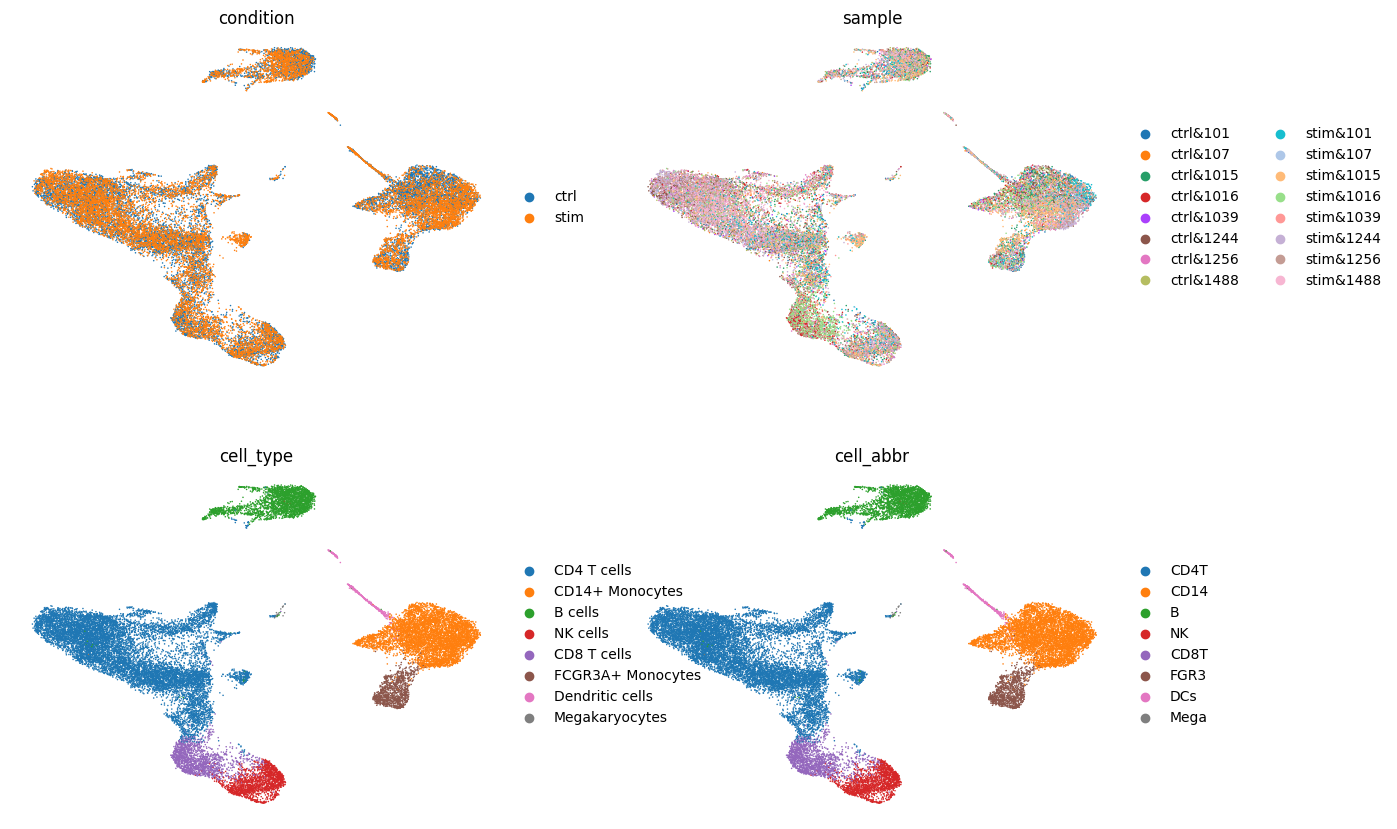

In [6]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

## Create a Multi-View Structure

To construct a multi-view structure, we need to define the views. In this case, we will use the `adata_to_views` function from liana to create a list of views (stored in a MuData object), where each view corresponds to a cell type.
Simply put, we summarize the samples to pseudobulks by cell type, and then we create a view for each cell type. 

We refer users to decoupler's `get_pseudobulk` function for more information about filtering and aggregation options.

In [7]:
mdata = li.multi.adata_to_views(adata,
                                groupby=groupby,
                                sample_key=sample_key,
                                obs_keys=['condition', 'patient'], # add those to mdata.obs
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True
                                )

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Let's check the newly created MuData object:

In [8]:
mdata

MuData object with n_obs × n_vars = 16 × 23071
  obs:	'condition', 'patient'
  7 modalities
    CD14:	16 x 3307
    CD4T:	16 x 2719
    DCs:	10 x 4781
    NK:	14 x 2791
    CD8T:	11 x 2523
    B:	16 x 3135
    FGR3:	11 x 3815

We see that we have 7 modalities (views) that correspond to the sufficiently abundant cell types & genes in the data.

## Pre-process the pseudobulk profiles

Next, we will normalize each of the views independently to ensure that samples are comparable.
We will also identify the highly-variable genes per view (i.e. across samples) - this is optional & dependent on our assumptions.

In [9]:
for view in mdata.mod.keys():
    
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])
    
    sc.pp.highly_variable_genes(mdata.mod[view])

In [10]:
mdata.mod['B']

AnnData object with n_obs × n_vars = 16 × 3135
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

**Note**
    
<h5> View Representation </h5>

MOFA supports the flexible representation of views, where each view can represent a different type of features (e.g. genes, proteins, metabolites, etc.). In this case, we simply allow for different genes to be used in each view.

</div>  

## Fitting a MOFA model

Now that the single-cell data is transformed into a multi-view representation, we can use MOFA to run a multicellular factor analysis.

We will attempt to capture the variability across samples and the different cell-types by reducing the data into a number of factors, where each factor captures the coordinated gene expression across cell types.

In [11]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           n_factors=5,
           outfile='models/mofacell.h5ad',
           use_var='highly_variable'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CD14' group='group1' with N=16 samples and D=3307 features...
Loaded view='CD4T' group='group1' with N=16 samples and D=2719 features...
Loaded view='DCs' group='group1' with N=16 samples and D=4781 features...
Loaded view='NK' group='group1' with N=16 samples and D=2791 features...
Loaded view='CD8T' group='group1' with N=16 samples and D=2523 features...
Loaded vi

## Exploring the MOFA model

For convenience, we provide simple getter function to access the model parameters, in addition to those available via the [MuData API](https://mudata.readthedocs.io/en/latest/api/index.html) & the MOFA model itself.

#### Explore Factor scores

In [12]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,condition,patient
0,ctrl&101,-0.613505,0.027125,-0.017782,0.028896,-0.020074,ctrl,patient_101
1,ctrl&1015,-0.488549,-0.004203,-0.014605,0.014504,-0.005313,ctrl,patient_1015
2,ctrl&1016,-0.489170,-0.003829,-0.027595,0.039114,-0.008760,ctrl,patient_1016
3,ctrl&1039,-0.544035,0.056854,0.014446,0.005816,0.087615,ctrl,patient_1039
4,ctrl&107,-0.604194,-0.076132,0.078726,0.003908,-0.018695,ctrl,patient_107


Let's check if any of the factors are associated with the sample condition:

In [13]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

In [14]:
# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))
    

Ttest_relResult(statistic=-57.50121474068924, pvalue=1.2623463113879605e-10)
Ttest_relResult(statistic=0.02286479075513679, pvalue=0.982396255039769)
Ttest_relResult(statistic=-0.09375922004304381, pvalue=0.9279276589739828)
Ttest_relResult(statistic=0.8836448796274801, pvalue=0.40621165822985117)
Ttest_relResult(statistic=0.3324197812779196, pvalue=0.7493051372546131)


We can see that the first factor is associated with the sample condition, let's plot the factor scores:

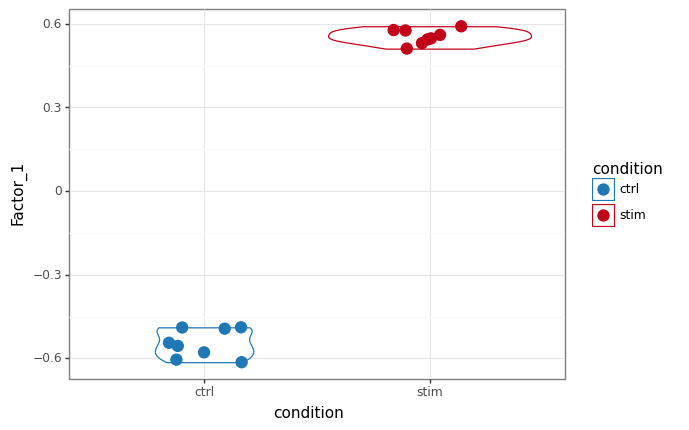

<ggplot: (8763315599856)>

In [15]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw() +
 p9.scale_colour_manual(values=['#1f77b4', '#c20019'])
 )

#### Explore Feature loadings

Now that we have identified a factor that is associated with the sample condition, we can check the features with the highest loadings associated with each cell type:

In [16]:
factor1_loadings =  li.multi.get_variable_loadings(mdata, 0, view_separator=':') # get loadings for factor 1
factor1_loadings.head()

,loadings,view,variable
1300,3.141631,CD14,IFIT3
1298,3.115271,CD14,IFIT1
692,3.106500,CD14,CXCL11
2994,3.098662,CD14,TNFSF10
2476,3.089889,CD14,RSAD2


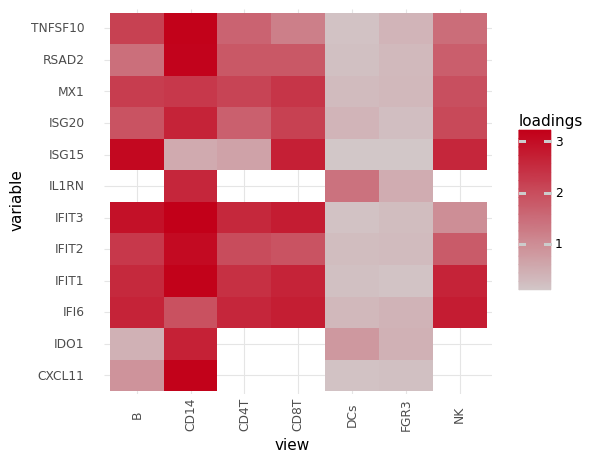

<ggplot: (8763315476535)>

In [17]:
# get top 25 genes across all views
top_genes = factor1_loadings['variable'].head(25)
top_loadings = factor1_loadings[factor1_loadings['variable'].isin(top_genes)]

# plot them
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) + 
 p9.aes(x='view', y='variable', fill='loadings') + 
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') + 
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=0.5), figure_size=(5, 5))
 )

Here, we that some genes are present in only some of the cell type views, and that among the top genes high loadings seem to be cell type specific.

### Explore the model

Finally, we can also explore the MOFA model itself and we will specifically check the variance explained by each cell type.

In [18]:
model = mofa.mofa_model("models/mofacell.h5ad")
model

MOFA+ model: mofacell.h5ad
Samples (cells): 16
Features: 23071
Groups: group1 (16)
Views: B (3135), CD14 (3307), CD4T (2719), CD8T (2523), DCs (4781), FGR3 (3815), NK (2791)
Factors: 5
Expectations: W, Z

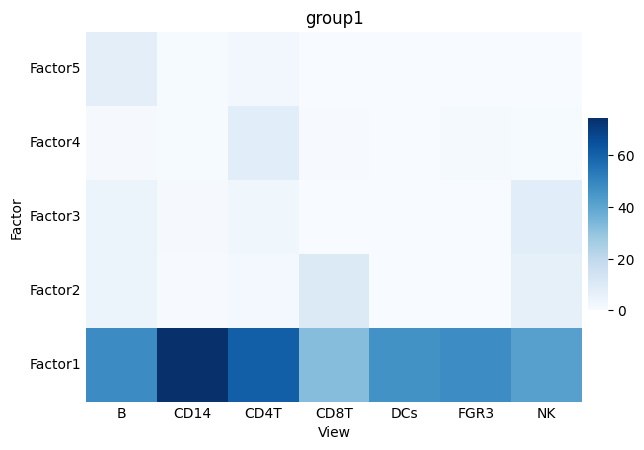

In [19]:
mofa.plot_r2(model, x='View')

We can see that Factor 1 captures the majority of the variance explained, and that CD14+ Monocytes have the highest R-squared for the first factor, in other words they are the most important cell type in explaining the variability between the two conditions.

## Outlook & Further Analysis

This tutorial is just a short introduction of the use of MOFA, we thus refer the users to the available [MOFA](https://biofam.github.io/MOFA2/tutorials.html) & [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/index.html) for more applications & details.

In [20]:
model.close()